## Logistic Regression - Data Science Portfolio - Maximilian Koch

**Dataset**: Spotify songs<br>
**Target variable**: Predicting whether a song is rock or not<br>
**Features**: Track information<br>
**Techniques applied**: Logistic regression, posterior distribution, odd ratios<br>

Logistic regression is ...

In this notebook, I will:

- Load and preprocess the Spotify song dataset
- Implement Logistic Regression
- Visualise the coefficient significance
- Interpret the odd ratios

### Preprocessing

In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
df = pd.read_csv('datasets/regression_dataset.csv')
df = df[['Danceability','Acousticness','Tempo','Popularity','Artist Genres','Explicit','Loudness','Speechiness',
'Instrumentalness','Mode','Album Release Date']].dropna()
df['Year'] = df['Album Release Date'].apply(lambda s: int(s[:4]))
df['Explicit'] = df['Explicit'].astype(int)

In [7]:
df['rock'] = df['Artist Genres'].apply(lambda genres: 1 if 'rock' in genres else 0)
df = df.drop(['Artist Genres','Album Release Date'],axis=1)

### Logistic regression

Using the homogenous model by just training the intercept:

In [44]:
df['intercept'] = 1.0
X = df[['intercept']]
y = df['rock']

logit_model = sm.Logit(y, X)
homogenous_result = logit_model.fit()
homogenous_result.summary()

Optimization terminated successfully.
         Current function value: 0.679623
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   rock   No. Observations:                 9446
Model:                          Logit   Df Residuals:                     9445
Method:                           MLE   Df Model:                            0
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:               2.678e-11
Time:                        22:20:43   Log-Likelihood:                -6419.7
converged:                       True   LL-Null:                       -6419.7
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3312      0.021    -15.875      0.000      -0.372      -0.290
==============================================================================
"""

Using the heterogenous model:

In [45]:
X = df.drop('rock',axis=1)
y = df['rock']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.525323
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   rock   No. Observations:                 9446
Model:                          Logit   Df Residuals:                     9434
Method:                           MLE   Df Model:                           11
Date:                Thu, 05 Dec 2024   Pseudo R-squ.:                  0.2270
Time:                        22:20:48   Log-Likelihood:                -4962.2
converged:                       True   LL-Null:                       -6419.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Danceability        -0.1982      0.603     -0.329      0.742      -1.381       0.984
Acousticness        -0.0804      0.237     -0.339      0.735      -0.546       0.385
Tempo             5.024e-05      0.001      0.051      0.959      -0.002       0.002
Popularity          -0.0003      0.001     -0.276      0.783      -0.002       0.002
Explicit            -0.1874      0.153     -1.227      0.220      -0.487       0.112
Loudness             0.0017      0.011      0.152      0.879      -0.020       0.023
Speechiness         -1.2469      0.898     -1.388      0.165      -3.007       0.513
Instrumentalness    -0.0051      0.224     -0.023      0.982      -0.443       0.433
Mode                 0.0337      0.084      0.400      0.689      -0.131       0.199
Year                -0.0008      0.009     -0.093      0.926      -0.018       0.016
intercept           -0.6156     17.803     -0.035      0.972     -35.508      34.277
predicted_prob       4.8393      0.693      6.980      0.000       3.481       6.198
====================================================================================
"""

The danceability and speechiness of a song seem to have the large negative influence on whether a song is classified as rock, additional to the explicitness and instrumentalness. The mode has a positive influence, with songs in major (mode = 1), apparently, being more related to rock than songs in minor (mode = 0).

Checking for multicollinearity:

In [11]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print(vif_data)

             feature           VIF
0       Danceability      1.142371
1       Acousticness      1.325536
2              Tempo      1.074333
3         Popularity      1.016028
4           Explicit      1.088328
5           Loudness      1.537880
6        Speechiness      1.109793
7   Instrumentalness      1.022691
8               Mode      1.044531
9               Year      1.299027
10         intercept  22508.081253


VIF values are pretty low, thus no obvious collinearity.

Comparing the heterogeneous and homogeneous model using AIC:

In [12]:
print('Homogenous:', homogenous_result.aic)
print('Heterogenous:', result.aic)

Homogenous: 12841.442216344305
Heterogenous: 9989.89069085187


The heterogeneous model has a lower AIC. Thus using the additional parameters explains the data better.
I will continue using that model for all following parts.

### Coefficient significance

Probability that Coefficients > 0:
Danceability        0.0000
Acousticness        0.0000
Tempo               0.7410
Popularity          0.0928
Explicit            0.0000
Loudness            0.0000
Speechiness         0.0000
Instrumentalness    0.0040
Mode                1.0000
Year                0.0000
intercept           1.0000
dtype: float64


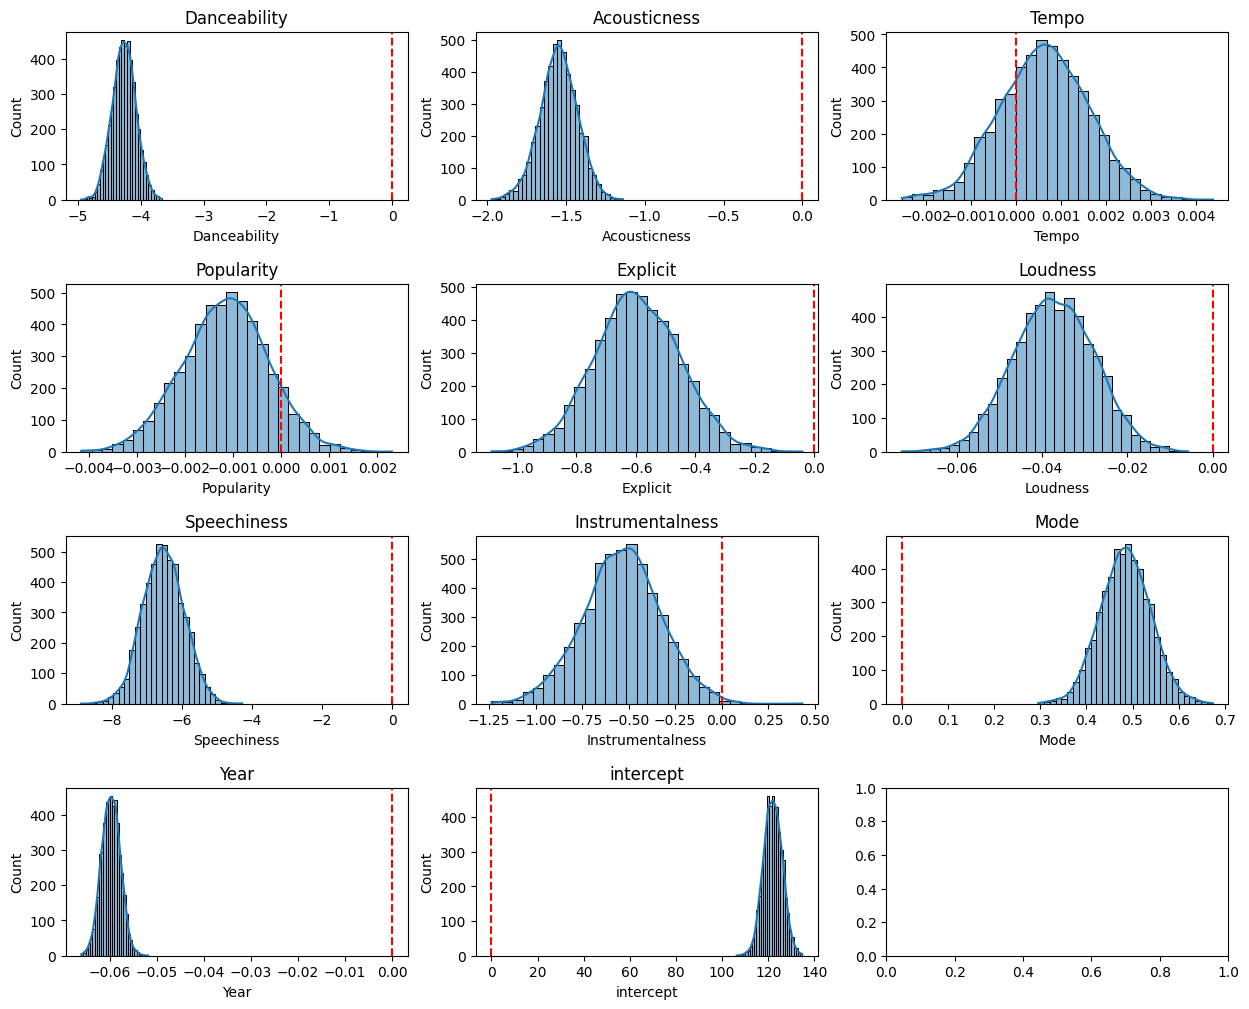

In [13]:
simulated_coeffs = np.random.multivariate_normal(result.params, result.cov_params(), size=5000)
simulated_coeffs_df = pd.DataFrame(simulated_coeffs, columns=X.columns)

# Calculate P(β > 0) for each coefficient
beta = (simulated_coeffs_df > 0).mean()
print("Probability that Coefficients > 0:")
print(beta)

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten() 
for i, col in enumerate(simulated_coeffs_df.columns):
    sns.histplot(simulated_coeffs_df[col], kde=True, bins=30, ax=axes[i])
    axes[i].axvline(0, color='red', linestyle='--')
    axes[i].set_title(f'{col}')

plt.subplots_adjust(hspace=0.5)
plt.show()

As observed in the results, almost all features have a significant influence on the logistic regression, except tempo, instrumentalness and popularity, which have no significance, as their coefficients go into different directions across simulations.

Showing predicted probabilities and posterior predictive distribution

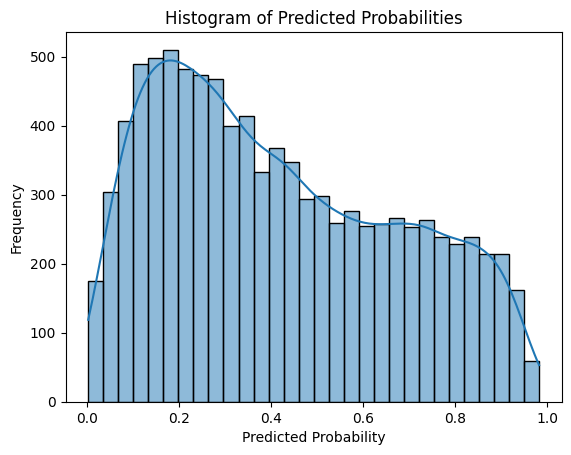

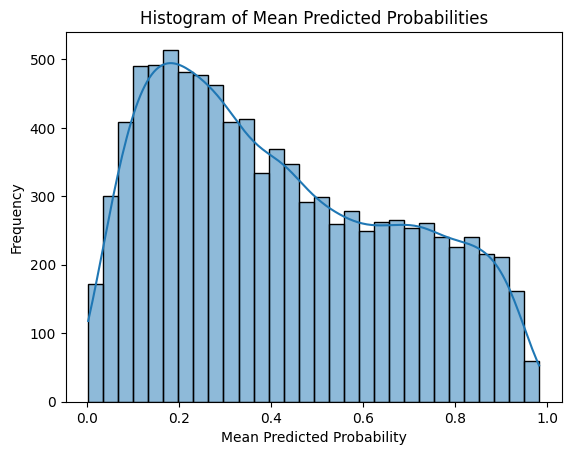

In [14]:
df['predicted_prob'] = result.predict(X)
sns.histplot(df['predicted_prob'], bins=30, kde=True)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

#Posterior predictive distribution
simulated_coeffs = np.random.multivariate_normal(result.params, result.cov_params(), size=1000)
X_matrix = X.values
simulated_probs = np.zeros((len(df), 1000))

for i in range(1000):
    beta_sim = simulated_coeffs[i]
    eta = np.dot(X_matrix, beta_sim)
    predicted_prob_sim = 1 / (1 + np.exp(-eta))
    simulated_probs[:, i] = predicted_prob_sim

mean_predicted_probs = simulated_probs.mean(axis=1)

sns.histplot(mean_predicted_probs, bins=30, kde=True)
plt.title('Histogram of Mean Predicted Probabilities')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Frequency')
plt.show()

### Odd ratios

In [42]:
coefficients = result.params
odds_ratios = np.exp(coefficients)
pd.options.display.float_format = '{:.5f}'.format #numpy was forcing scientific notation

print("Odds Ratios:")
print(odds_ratios)

Odds Ratios:
Danceability                                                  0.01399
Acousticness                                                  0.21283
Tempo                                                         1.00061
Popularity                                                    0.99882
Explicit                                                      0.55048
Loudness                                                      0.96348
Speechiness                                                   0.00145
Instrumentalness                                              0.58768
Mode                                                          1.62317
Year                                                          0.94196
intercept          96917429014383955836984920628610809528842797109...
dtype: float64


As also observed in the previous outputs, e.g. the danceability and explicitness have a strong negative influence on whether a song is rock music,
thus with a song being explicit, the odds of it being rock decrease by a factor of 0.21, with it being full on danceable the odds decrease by a factor of 0.01 and with a song written in the major mode (mode = 1), the odds increase by a factor of 1.62.